## Imports, installations, and constants
- Python imports
- defining directories and constants

In [0]:
# Sources
# --------
# Emil Wallner blog post and code on Floydhub for image colorization
# "Deep Koalarization": https://github.com/baldassarreFe/deep-koalarization
# "Colorful Image Colorization": https://github.com/richzhang/colorization
! rm -rf gif_train
! rm -rf metadata
! rm -rf model_params

In [3]:
# Sometimes, some funkiness comes up because the machine running this notebook
# doesn't have Keras, h5py, etc. We install those dependencies here.
! pip install keras
! pip install h5py

In [4]:
import numpy as np
import os
import random
import sys
import tensorflow as tf

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

import matplotlib
# This line was for some of our machines; some edge case
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

import keras
import keras.backend as K
from keras.activations import softmax
from keras.layers.core import RepeatVector
# Not sure we need all of these
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.losses import categorical_crossentropy
from keras.metrics import top_k_categorical_accuracy
from keras.models import Model, Sequential
from keras.preprocessing.image import array_to_img, img_to_array, load_img
# from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

Using TensorFlow backend.


In [5]:
# Paths and utilities
# -------------------
# Assuming this notebook's directory (<repository root>/model) is root.
data_dir = "../data/"
train_dir = data_dir + "train/"
test_dir = data_dir + "test/"
results_dir = "../results/"
gif_train_dir = data_dir + "gif_train/"
gif_image_dir = data_dir + "gif_train_image/"

model_chkpt = "model_params/"
model_metadata_dir = "metadata/"
model_name = "rainbownet"

if not os.path.isdir(model_metadata_dir):
  print("Didn't find %s. Creating it now" % model_metadata_dir)
  os.makedirs(model_metadata_dir)
if not os.path.isdir(model_chkpt):
  print("Didn't find %s. Creating it now" % model_chkpt)
  os.makedirs(model_chkpt)
if not os.path.isdir(train_dir):
  print("Didn't find %s. Creating it now" % train_dir)
  os.makedirs(train_dir)
if not os.path.isdir(test_dir):
  print("Didn't find %s. Creating it now" % test_dir)
  os.makedirs(test_dir)
if not os.path.isdir(results_dir):
  print("Didn't find %s. Creating it now" % results_dir)
  os.makedirs(results_dir)
if not os.path.isdir(gif_train_dir):
  print("Didn't find %s. Creating it now" % gif_train_dir)
  os.makedirs(gif_train_dir)
if not os.path.isdir(gif_image_dir):
  print("Didn't find %s. Creating it now" % gif_image_dir)
  os.makedirs(gif_image_dir)


# Adjustable constants
BATCH_SIZE = 16
N_EPOCHS = 1
GRID_SIZE = 8
NUM_TOTAL_BUCKETS = (256//GRID_SIZE)**2
# NUM_VALID_BUCKETS will be updated dynamically when computing buckets, 
#   if there is an inconsistency.
NUM_VALID_BUCKETS = 394 # with GRID_SIZE=8. 
BUCKET_ID_TO_INDEX = None
BUCKET_INDEX_TO_ID = None

# Python 3 peculiarities
if sys.version_info[0] == 3:
    xrange = range

Didn't find metadata/. Creating it now
Didn't find model_params/. Creating it now


## Utility Functions. Stuff to help make this notebook work on remote machines, etc. during our development process.
**NOT NECESSARY** to run, 

unless you want to download a gif of a flying puppy for training data.

Not the meat of the actual model/algorithms. 
- Downloading files from Google Drive
- Splitting GIF's into frames
- Splitting GIF's from Google Drive into frames (wowowowow)

### Downloading a file from Google Drive

In [0]:
# Copied from https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive

import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        # DANG i havent seen "chunk" since 107
        # good times

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

# example:
# download_file_from_google_drive("1H5aWTvlodzLA_hwm68BHtJbrvuKYt0hh", "test.jpg")

In [0]:
from PIL import Image
import sys
import os
import urllib

SAVE_DIR = train_dir

def process_gif(infile):
    try:
        image = Image.open(infile)
    except IOError:
        print "Can't load", infile
        sys.exit(1)
    palette = image.getpalette()
    name = os.path.split(infile)[-1].split('.')[0]

    # save_dir = os.path.join(SAVE_DIR, name)
    save_dir = train_dir # temp, to put data in train_dir root instead
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    try:
        i = 0
        while True:
            image.putpalette(palette)
            new_image = Image.new("RGB", image.size)
            new_image.paste(image)
            new_image.save(os.path.join(save_dir, str(i) + "-" + name + '.jpg'))

            i += 1
            image.seek(image.tell() + 1)

    except EOFError:
        pass # end of sequence
    
    print("Finished processing gif", infile)

In [8]:
"""
Download a gif of a flying puppy and split it into frames
Run this to populate gif_train_dir with images as a toy example.
"""

download_file_from_google_drive("1ppGwWuu5J3ecEdwXJbBXzg4FOktbI1Cv", gif_train_dir + "gif1.gif")
process_gif(gif_train_dir + "gif1.gif")

('Finished processing gif', '../data/gif_train/gif1.gif')


In [9]:
# ! mv /data/train/0-gif1.png /data/test/0-gif1.png
# ! mv /data/train/1-gif1.png /data/test/1-gif1.png
# ! mv /data/train/2-gif1.png /data/test/2-gif1.png
# ! mv /data/train/3-gif1.png /data/test/3-gif1.png
# ! mv /data/train/4-gif1.png /data/test/4-gif1.png
# ! mkdir /results


! ls ../data/test
! echo --------------------
! ls ../data/train
! echo --------------------
! ls ../results

0-gif1.jpg
--------------------
0-gif1.jpg   17-gif1.jpg  24-gif1.jpg  31-gif1.jpg  39-gif1.jpg  5-gif1.jpg
10-gif1.jpg  18-gif1.jpg  25-gif1.jpg  32-gif1.jpg  3-gif1.jpg	 6-gif1.jpg
11-gif1.jpg  19-gif1.jpg  26-gif1.jpg  33-gif1.jpg  40-gif1.jpg  7-gif1.jpg
12-gif1.jpg  1-gif1.jpg   27-gif1.jpg  34-gif1.jpg  41-gif1.jpg  8-gif1.jpg
13-gif1.jpg  20-gif1.jpg  28-gif1.jpg  35-gif1.jpg  42-gif1.jpg  9-gif1.jpg
14-gif1.jpg  21-gif1.jpg  29-gif1.jpg  36-gif1.jpg  43-gif1.jpg
15-gif1.jpg  22-gif1.jpg  2-gif1.jpg   37-gif1.jpg  44-gif1.jpg
16-gif1.jpg  23-gif1.jpg  30-gif1.jpg  38-gif1.jpg  4-gif1.jpg
--------------------


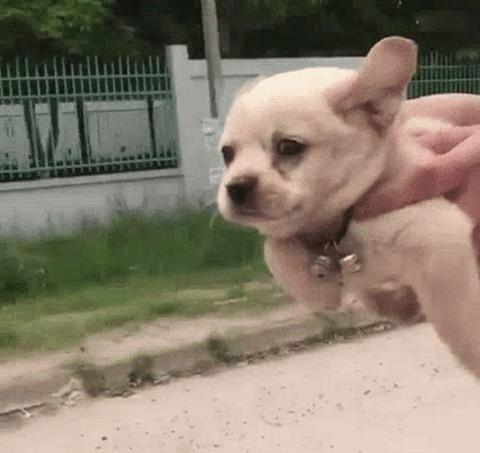

In [10]:
# Get something into test_dir = "../data/test".

! mv ../data/train/0-gif1.jpg ../data/test/0-gif1.jpg
from IPython.display import Image 


image1 = os.listdir(train_dir)[23]
Image(train_dir + image1)

## Helper Functions
Stuff we're using in the other functions below.

In [0]:
def resize_images(images, shape):
  """ Does exactly what it sounds like it does.
      |shape|: a 3-tuple of the dimensions to resize to. 
               (H, W, 3) usually.
  """
  resized = []
  for i in images:
    im = resize(i, shape, mode='constant')
    resized.append(im)
  resized = np.array(resized)
  return resized

In [0]:
def debug(obj, name, plimit=500):
    typ = type(obj)
    typstr = str(typ)
    
    # for debugging ndarray shape (large use case)
    shape = "(N/A)"
    if typ == type(np.array([0])):
      shape = obj.shape
    else:
      try:
        shape = "len=" + str(len(obj))
      except TypeError:
        pass
    shapestr = str(shape)

    objstr = str(obj)
    objout = objstr if len(objstr) < plimit else objstr[:plimit] + "\n[... %s output truncated]" % name
    
    outputs = [typstr, shapestr, name + ":\n", objout]
    print " ".join(outputs)

## **The Inception ResNet Fusion**

We're going to be using Google's Inception ResNet v2 to augment our CNN. This model has been highly trained on millions of examples, and can detect features that would be useful in colorizing our test images. The fusion of IRNet features with our CNN will come later in RainbowNetModel(). For now, these functions load the model and set up predictions.



In [0]:
def load_inception_net(weights_path):
  inception = InceptionResNetV2(weights=None, include_top=True)
  inception.load_weights(weights_path)
  inception.graph = tf.get_default_graph()
  return inception

In [0]:
def create_inception_embedding(grayscaled_rgb):
  """ One forward pass through the InceptionResNet for one image,
      to give said image a 1000-vector embedding of it's features.
      
      |grayscaled_rgb|: the images we are embedding in grayscale. 
      
      :return: (None, 1000) vector.
  """
  # Resize all the images to (299, 299, 3).
  grayscaled_rgb_resized = resize_images(grayscaled_rgb, (299, 299, 3))

  # preprocessing for the Inception resnet
  grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)

  # Predict.
  with inception.graph.as_default():
    embed = inception.predict(grayscaled_rgb_resized)
  
  return embed

## Finding our color buckets
This is how we discretized the *ab* channels' color space into buckets for our model.


In [0]:
def get_bucket_id(ab_pixel):
    """ Given an ab coordinate, find the id of the bucket of
        that it belongs to.
        
        |ab_pixel|: np.array of shape (2,).
    """
    a = int(ab_pixel[0])
    b = int(ab_pixel[1])
    #print("We have a,b=%s" % (str((a,b))))
    
    bucket_row = (a + 128) // GRID_SIZE
    bucket_col = (b + 128) // GRID_SIZE
    bucket_id = bucket_row * (256 // GRID_SIZE) + bucket_col
    
    return bucket_id
  
def discretize_ab_space():
    # initialize a blank array of (# buckets, 2).
    space = np.zeros(((256//GRID_SIZE)**2, 2))
    
    bucket_index = 0
    for a in xrange(-128, 128, GRID_SIZE):
        for b in xrange(-128, 128, GRID_SIZE):
            a_mid = float(a + GRID_SIZE / 2)
            b_mid = float(b + GRID_SIZE / 2)
            space[bucket_index] = a_mid, b_mid
            bucket_index += 1

    return space

def compute_bucket_maps(bucket2ab_map=None, ab2bucket_map=None):
    global BUCKET_ID_TO_INDEX
    global BUCKET_INDEX_TO_ID
    
    # 1) Get our monte carlo ab color space.
    # Note: skimage.color's rgb2lab takes in RGB values normalized to [0,1].
    # Step sizes of 3 for R,G,B is granular enough for our purposes,
    #   in sampling RGB space.
    all_rgb_normed = [[r/255., g/255., b/255.] for r in xrange(0,256) \
                                               for g in xrange(0,256) \
                                               for b in xrange(0,256)]
    print("compute_bucket_maps(): finished getting all_rgb_normed")
    
    NUM_RGB_SAMPLES = len(all_rgb_normed)
    all_rgb_normed = np.array(all_rgb_normed)
    all_rgb_normed = all_rgb_normed[:, np.newaxis, :]        # (#rgb colors, 1, 3=rgb)
    assert all_rgb_normed.shape == (NUM_RGB_SAMPLES, 1, 3) #  new axis because skimage demands it.
    ab_colors = rgb2lab(all_rgb_normed)                    # (#rgb colors, 1, 3=lab)
    ab_colors = np.squeeze(ab_colors)[:,1:]                # (#rgb colors, 2=ab)
    assert ab_colors.shape == (NUM_RGB_SAMPLES, 2)
    
    # 2) Get our buckets. 
    # ab_buckets[bucket #] = (a,b) coord for that bucket, even if it isn't a valid RGB.
    ab_buckets_centers = discretize_ab_space()             # (#buckets, 2=ab)
    assert ab_buckets_centers.shape == (NUM_TOTAL_BUCKETS, 2)
    
    # 3) Now we calculate the closest bucket for each ab color.
    closest = [get_bucket_id(color) for color in ab_colors]
    # closest = [np.argmin(np.linalg.norm(ab_buckets_centers - color, axis=1)) for color in ab_colors]
    valid_buckets = set(closest)
    
    # aside: for interpreting the softmax in the rainbowModel later, we need to know which neuron predicts which bucket
    BUCKET_ID_TO_INDEX = {bucket_id : i for i, bucket_id in enumerate(list(valid_buckets))}
    BUCKET_INDEX_TO_ID = {i : bucket_id for i, bucket_id in enumerate(list(valid_buckets))}
    debug(BUCKET_ID_TO_INDEX, "id to index", plimit=2000)
    debug(BUCKET_INDEX_TO_ID, "index to id", plimit=2000)
    
    # 4) Create the maps.
    bucket2ab_map = {bucket : tuple(ab_buckets_centers[bucket]) for bucket in valid_buckets}
    # Assert there are no repeats in the map
    assert len(bucket2ab_map.values()) == len(set(bucket2ab_map.values()))
    ab2bucket_map = {bucket2ab_map[bucket] : bucket for bucket in bucket2ab_map}
    assert len(ab2bucket_map.values()) == len(set(ab2bucket_map.values()))
    
    print ("There are %d final buckets." % len(bucket2ab_map))
    print ("There are %d final colors." % len(ab2bucket_map))
    
    return bucket2ab_map, ab2bucket_map

def plot_mapping(bucket2ab_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    for bucket in bucket2ab_map:
        a_mid = bucket2ab_map[bucket][0]
        a_low = a_mid - GRID_SIZE / 2
        b_mid = bucket2ab_map[bucket][1]
        b_low = b_mid - GRID_SIZE / 2

        lab_pixel = np.array([50., a_mid, b_mid])
        lab_pixel = np.reshape(lab_pixel, (1, 1, 3))
        rgb = tuple(lab2rgb(lab_pixel)[0][0])

        ax.add_patch(
            patches.Rectangle(
                (b_low, -a_low), 
                GRID_SIZE, 
                GRID_SIZE, 
                facecolor=rgb
            )
        )

    plt.xlim([-128, 128])
    plt.ylim([-128, 128])
    plt.show()

In [0]:
# Un-comment and run this if you want to remove existing pickles, and recompute the maps.
! rm -f metadata/*.pkl

compute_bucket_maps(): finished getting all_rgb_normed
<type 'dict'> len=394 id to index:
 {183: 0, 184: 1, 185: 2, 186: 3, 212: 4, 213: 5, 214: 6, 215: 7, 216: 8, 217: 9, 218: 10, 242: 11, 243: 12, 244: 13, 245: 14, 246: 15, 247: 16, 248: 17, 249: 18, 250: 19, 272: 20, 273: 21, 274: 22, 275: 23, 276: 24, 277: 25, 278: 26, 279: 27, 280: 28, 281: 29, 282: 30, 302: 31, 303: 32, 304: 33, 305: 34, 306: 35, 307: 36, 308: 37, 309: 38, 310: 39, 311: 40, 312: 41, 313: 42, 314: 43, 315: 44, 333: 45, 334: 46, 335: 47, 336: 48, 337: 49, 338: 50, 339: 51, 340: 52, 341: 53, 342: 54, 343: 55, 344: 56, 345: 57, 346: 58, 347: 59, 364: 60, 365: 61, 366: 62, 367: 63, 368: 64, 369: 65, 370: 66, 371: 67, 372: 68, 373: 69, 374: 70, 375: 71, 376: 72, 377: 73, 378: 74, 379: 75, 395: 76, 396: 77, 397: 78, 398: 79, 399: 80, 400: 81, 401: 82, 402: 83, 403: 84, 404: 85, 405: 86, 406: 87, 407: 88, 408: 89, 409: 90, 410: 91, 411: 92, 426: 93, 427: 94, 428: 95, 429: 96, 430: 97, 431: 98, 432: 99, 433: 100, 434: 101

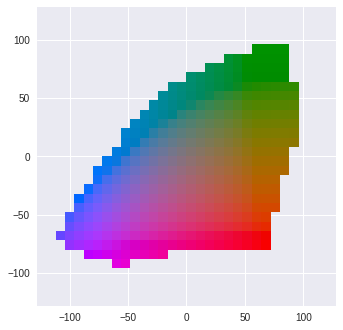

We have in the map 394 buckets.
Buckets loaded successfully!


In [17]:
"""
The script for loading our bucket maps.
If there are .pkl's of maps we've stored from a previous computation,
    load those.
Otherwise, run compute_bucket_maps() to get them, and dump into
    pickles for the future.
"""

# To open: `map = pickle.load(open(<filename>, 'r'))`
BUCKET2AB = model_metadata_dir + 'bucket2ab_map.pkl'
AB2BUCKET = model_metadata_dir + 'ab2bucket_map.pkl'

bucket2ab_map = None
ab2bucket_map = None

# No pickles found. Compute the maps.
if not os.path.isfile(BUCKET2AB) or not os.path.isfile(AB2BUCKET):
  bucket2ab_map, ab2bucket_map = compute_bucket_maps()
  
  pickle.dump(bucket2ab_map, open(BUCKET2AB, 'wb'))
  pickle.dump(ab2bucket_map, open(AB2BUCKET, 'wb'))
  
# We found the pickles! Load them.
else:
  print("Loading buckets from pickle.")
  bucket2ab_map = pickle.load(open(BUCKET2AB, 'rb'))
  ab2bucket_map = pickle.load(open(AB2BUCKET, 'rb'))

plot_mapping(bucket2ab_map)
# --------------------------

print("We have in the map %d buckets." % len(bucket2ab_map))
if NUM_VALID_BUCKETS != len(bucket2ab_map):
  print("NUM_VALID_BUCKETS=%s does not match the number of buckets we computed."
         % str(NUM_VALID_BUCKETS))
  print("Setting NUM_VALID_BUCKETS=%d" % len(bucket2ab_map))
  NUM_VALID_BUCKETS = len(bucket2ab_map)

print("Buckets loaded successfully!")

# bucket2ab_map: map of bucket # to (a, b)
# ab2bucket_map: map of (a, b) to bucket #
# use get_bucket(lab_pixel, ab2bucketmap) to get corresponding (a, b)

## Bucketing for images
The following two functions are for turning an *Lab* image(s) into an array of bucket labels, and the converse.

In [0]:
def discretize(images_ab):
  """ This is a preprocessing step, that will be used in converting 
      Y (ab image true labels) into buckets, so that we can calculate
      a loss in colorization_loss().
  
      |images_ab|: (m, H, W, 2) array representing ab channels of images.
  
      :return: (m, H, W, 1) array where each entry is in BUCKET_ID_TO_INDEX.
               One of the NUM_VALID_BUCKETS color buckets we found.
  """
  if len(images_ab.shape) == 3:
    print("discretize(): detected only 3 dims, reshaping to (m=1,:,:,:)")
    images_ab = images_ab[np.newaxis,:,:,:]
    
  assert BUCKET_ID_TO_INDEX is not None
  
  m, H, W, _ = images_ab.shape
  images_d = np.zeros((m, H, W))

  for i in xrange(m):
    for h in xrange(H):
      for w in xrange(W):
        ab_pixel = images_ab[i,h,w]
        bucket_id = get_bucket_id(ab_pixel)
        #print("We got bucket id %d" % bucket_id)
        #debug(BUCKET_ID_TO_INDEX, "id to index", plimit=2000)
        #assert bucket_id in BUCKET_ID_TO_INDEX
        images_d[i,h,w] = BUCKET_ID_TO_INDEX[bucket_id]
  
  return images_d

In [0]:
# This function will be called when we want to demo a predicted image.
# It takes an image with pixels labeled with buckets, and transforms it
#   into 2 color channels.

def inverse_discretize(images_d):
  """ The inverse of the above function. Maps the indicated bucket to
      the mean of that bucket.
      
      |images_d|: an array (m,H,W) with the color bucket assigned to each
                  pixel.
                  
      :return: (m, H, W, 2) array with ab color values.
  """
  if len(images_d.shape) == 2:
    print("inverse_discretize(): detected only 2 dims, reshaping to (m=1,:,:)")
    images_d = images_d[np.newaxis,:,:]

  m, H, W = images_d.shape
  images_ab = np.zeros((m, H, W, 2))
  
  for i in xrange(m):
    for h in xrange(H):
      for w in xrange(W):
        bucket = images_d[i,h,w]
        images_ab[i,h,w] = bucket2ab_map[bucket] # Sets to [a,b]
  
  return images_ab
  

## Getting the data
This function loads the data, for training and for test.

```preprocess_data()``` then processes them for input into our CNN. This involves converting to *Lab* and separating the channels, running through InceptionResnet, and normalizing the *L* channel input.

In [0]:
# Examples of use:
# load_data(train_dir)
# load_data(test_dir)

def load_data(directory):
    """ Load an entire set of |m| examples. If loading entire dataset takes
      too much memory, may have to run in batches: 
      train, save chkpt.
      Put new examples in the directory.
      Repeat. 
    """
    images = []
    for filename in os.listdir(directory):
      image = load_img(directory + filename)  # PIL image
      images.append(img_to_array(image))      # np.array

    images = np.array(images, dtype=float)
    return images
  

In [21]:
# Get the weights for inception resnet if we don't have them
# ----------------------------------------------------------
weights_path = model_metadata_dir + "inception_resnet_v2_weights.h5"
weights_id = "1L9cHTdvBocGHi-SJmgR_27ak6OPudJDc"
if not os.path.isfile(weights_path):
  print ("Didn't find the inception resnet weights. Downloading them.")
  download_file_from_google_drive(weights_id, weights_path)

# initialize inception resnet, for use in |preprocess_data()|
# -----------------------------------------------------------
try:
    assert type(inception) == keras.engine.training.Model
except (NameError, AssertionError):  
    inception = load_inception_net(weights_path)

print ("Loaded Inception Resnet model for generating image embeddings.")


Didn't find the inception resnet weights. Downloading them.
Loaded Inception Resnet model for generating image embeddings.


In [0]:
def analyze_images(images):
  # 4d images
  L = images[:,:,:,0]
  A = images[:,:,:,1]
  B = images[:,:,:,2]
  print("stats on channel1: min %s, max %s" % (np.amin(L), np.amax(L)))
  print("stats on channel2: min %s, max %s" % (np.amin(A), np.amax(A)))
  print("stats on channel3: min %s, max %s" % (np.amin(B), np.amax(B)))

In [0]:
def homemade_to_categorical(y):
    #shape (m, 224, 224)
    m, H, W = y.shape
    categorical = np.zeros((m, H, W, NUM_VALID_BUCKETS))
    for i in xrange(m):
      for h in xrange(H):
        for w in xrange(W):
          index = int(y[i,h,w])
          categorical[i,h,w,index] = 1.
    return categorical

In [0]:
def preprocess_data(images):
    """ Preprocess the data for input into our rainbownet model.
    """
    
    print("preprocess_data(): obtained %d images." % len(images))

    analyze_images(images)
    # Resize them to (224,224)
    print("preprocess_data(): Resizing")
    images_resized = resize_images(images, (224, 224, 3))
    
    # Get the inception embeddings from grayscaled images. 
    #   This will be part of our passed in input.
    print("preprocess_data(): Creating inception embeddings")
    grayscaled_images = gray2rgb(rgb2gray(images_resized))
    embs = create_inception_embedding(grayscaled_images) # a numpy array

    # Normalize the resized images (which are in RGB) to [0,1] to prepare for rgb2lab.
    images_normed = images_resized - np.amin(images_resized, axis=(1,2), keepdims=True)
    images_normed = images_normed / np.amax(images_normed, axis=(1,2), keepdims=True)
    analyze_images(images_normed)
    
    # Transform to lab. Separate the l- and ab- channels
    print("preprocess_data(): Separating L and ab channels")
    images_lab = rgb2lab(images_normed)
    analyze_images(images_lab)
    images_l = images_lab[:,:,:,0,np.newaxis]     # shape (m, H, W, n_frames=1 for now)
    images_ab = images_lab[:,:,:,1:]              # shape (m, H, W, 2) 
    
    # Normalize L channel to be between 0, 1.
    print("preprocess_data(): Normalizing L channel to [0,1]")
    bottom = np.amin(images_l, axis=(1,2), keepdims=True)
    images_l -= bottom
    top = np.amax(images_l, axis=(1,2), keepdims=True)
    images_l /= top

    # Create X, composed of L channel + the embedding
    # Create Y, including discretizing the ab image
    X = [images_l, embs]         # tuple: (m, H, W), (m, 1000)
    print("preprocess_data(): discretizing Y")
    Y = discretize(images_ab)       # shape (m, H, W)
    
    print("preprocess_data(): changing Y to one-hot categorical vectors")
    Y = homemade_to_categorical(Y)
    
    print("preprocess_data(): done. returning X, Y")
    return X, Y

## Defining our loss
Our colorization loss is the softmax cross-entropy between the multinomial color distributions of every pixel in ```y_true``` and ```y_pred``` over all pixels (H,W), over all images in the minibatch. Inspired by the colorization paper, to solve issues other losses like MSE face.

TODO: implement color weighting, like in Richard Zhang et al.



In [0]:
def colorization_loss(y_true, y_pred):
  """ |y_true|: Our true colors. An array (batch_size, H, W) with entries 
                specifying one of the buckets that pixel's color is in.
      |y_pred|: A (batch_size, H, W, NUM_VALID_BUCKETS) volume with last dimension a
                softmax over bucket probabilities.
  
      This loss involves computing the softmax cross-entropy over pixel's
        predicted color bucket, over all images in the batch.
  """
  # softmax cse with logits for each pixel
  
  # https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten
  # It conveniently ignores the batch axis 0.
  #print y_true.get_shape()
  #y_true = np.array(y_true)
  #debug(y_true, "y_true before flattening")
  #y_true_flat = y_true.flatten()
  #debug(y_true_flat, "y_true flat")
  y_true_flat = tf.contrib.layers.flatten(y_true)
  #y = np.array(y_true_flat)
  #y_pred = np.array(y_pred)
  #debug(y_pred, "y_pred before flattening")
  #y_pred_flat = y_pred.flatten()
  #debug(y_pred_flat, "y pred flat")

  #print(y_true_flat.get_shape())
  
  # Turns into one-hot representation
  #y_true_cat = to_categorical(y_true_flat, num_classes=NUM_VALID_BUCKETS)
  #flatten one more time
  #y_true_flat_final = tf.contrib.layers.flatten(y_true_cat)
  y_pred_flat = tf.contrib.layers.flatten(y_pred)
  
  return categorical_crossentropy(y_true_flat, y_pred_flat)

## Defining our model


In [0]:
def RainbowNetModel():
  # THE MEAT OF THE CODE
  # Based off of the colorization paper's architecture. Keep in mind they trained
  #   on ImageNet though.
  
  # Input will have to be modified for doing image seqs. 
  #   In particular the volume is probably not 1 channel, but n_frames channels.
  embedding_input = Input(shape=(1000,))
  encoder_input = Input(shape=(224, 224, 1,))

  # NOTE: The number of times we do "strides=2" is the 
  #   same as the number of times we do Upsampling2D. 

  # TODO: look into BN parameters, maybe we can configure them more specifically
  
  # Encoder
  # -------
  encoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(encoder_input)
  encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input) #112
  encoder_output = BatchNormalization()(encoder_output)
  
  encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
  encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output) #56
  encoder_output = BatchNormalization()(encoder_output)
  
  encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
  encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output) #28
  encoder_output = BatchNormalization()(encoder_output)
  
  # May have to reduce layers if we don't have enough training data, to avoid overfitting.
  encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
  encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
  encoder_output = BatchNormalization()(encoder_output)


  # Fusion
  # ------
  fusion_output = RepeatVector(28 * 28)(embedding_input) 
  fusion_output = Reshape(([28, 28, 1000]))(fusion_output)
  fusion_output = concatenate([encoder_output, fusion_output], axis=3)  # Stack along thickness dimension
  
  # A volume that solidifies the fusion from the inception-resnet vectors + our previous volume:
  fusion_output = Conv2D(512, (1, 1), activation='relu', padding='same')(fusion_output) 


  #Decoder
  # May have to reduce layers if we don't have enough training data, to avoid overfitting.
  decoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(fusion_output) # 28
  decoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(decoder_output)
  decoder_output = BatchNormalization()(decoder_output)
  decoder_output = UpSampling2D((2, 2))(decoder_output) # 56
  
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
  decoder_output = BatchNormalization()(decoder_output)
  decoder_output = UpSampling2D((2, 2))(decoder_output) # 112
  
  decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
  decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
  decoder_output = BatchNormalization()(decoder_output)
  decoder_output = UpSampling2D((2, 2))(decoder_output) # 224
  
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
  decoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(decoder_output)
  
  def softmax_for_rainbownet(x):
    return softmax(x, axis=2)

  softmax_output = Conv2D(NUM_VALID_BUCKETS, (3,3), activation=softmax_for_rainbownet, padding='same')(decoder_output)
  
  model = Model(inputs=[encoder_input, embedding_input], outputs=softmax_output)
  return model

In [0]:
def save_model(model, model_save_path):
  model_json = model.to_json()
  with open(model_save_path + model_name + ".json", "w") as json_file:
    json_file.write(model_json)
  model.save_weights(model_save_path + model_name + ".h5")

In [0]:
def load_existing_model():
  weights_path = model_chkpt + model_name + ".h5"

  if not os.path.isfile(weights_path):
    print("The model at path %s was not found." % weights_path)
    quit()
    
  model = RainbowNetModel()
  rainbowModel.load_weights(weights_path)
  return model

## Baseline for comparison

In [0]:
def preprocess_baseline_data(images):
    images_resized = resize_images(images, (224, 224, 3))
    X = rgb2lab(1.0 / 255 * images_resized)[:,:,:,0]
    Y = rgb2lab(1.0 / 255 * images_resized)[:,:,:,1:] / 128.
    
    X = X.reshape((len(X), np.prod(X.shape[1:])))
    Y = Y.reshape((len(Y), np.prod(Y.shape[1:])))
    return X, Y

In [0]:
def BaselineModel():
    inputs = Input(shape=(224 * 224,))
    encoded = Dense(224, activation='relu')(inputs)
    decoded = Dense(224 * 224 * 2, activation='tanh')(encoded)
    return Model(inputs, decoded)

In [45]:
# Load the training data
images_train = load_data(test_dir) # CHANGE TO train_dir LATER
X_train, Y_train = preprocess_baseline_data(images_train)
print("Loaded X_train " + str(X_train.shape))
print("Loaded Y_train " + str(Y_train.shape))

# Load the test data
images_test = load_data(test_dir)
X_test, Y_test = preprocess_baseline_data(images_test)
print("Loaded X_test " + str(X_test.shape))
print("Loaded Y_test " + str(Y_test.shape))

# Initialize our baseline model, and train it
baselineModel = BaselineModel()
baselineModel.compile(optimizer='sgd', loss='mean_squared_error')
baselineModel.fit(x=X_train, y=Y_train, batch_size=2, epochs=5)

print('===')

# Evaluate on the test set, and print our loss.
print baselineModel.evaluate(X_test, Y_test, batch_size=1)
test_output = baselineModel.predict(X_test)

debug(test_output[0], "test_output")   # The (224*224*2)-vector that the baseline predicted from X_test[0]
debug(Y_test[0], "Y_test")        # The ground truth, Y_test[0], corresponding to it.

# Save the results of prediction (in test_output) into the results_dir.
num_test_examples = len(X_test)
for i in range(num_test_examples):
    # The empty array holding our formatted-into-a-picture result
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = X_test[i].reshape((224, 224))                        # Set the L channel
    cur[:,:,1:] = test_output[i].reshape((224, 224, 2)) * 128         # Set the ab channels as our prediction
    imsave(results_dir + "img_" + str(i) + ".png", lab2rgb(cur))      # Save it.
    cur[:,:,1:] = Y_test[i].reshape((224, 224, 2)) * 128              # Set the ab channels as ground truth
    imsave(results_dir + "img_" + str(i) + "_og.png", lab2rgb(cur))   # Save it too.

Loaded X_train (1, 50176)
Loaded Y_train (1, 100352)
Loaded X_test (1, 50176)
Loaded Y_test (1, 100352)
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.8174
Epoch 2/5
1/1 [==============================] - 0s 310ms/step - loss: 0.7004
Epoch 3/5
1/1 [==============================] - 0s 308ms/step - loss: 0.0110
Epoch 4/5
1/1 [==============================] - 0s 305ms/step - loss: 0.0067
Epoch 5/5
1/1 [==============================] - 0s 305ms/step - loss: 0.0067
===
1/1 [==============================] - 1s 746ms/step
0.00673243077472
<type 'numpy.ndarray'> (100352,) test_output:
 [ -7.11693957e-08  -5.41121317e-08   5.60244828e-09 ...,   5.44481686e-08
   2.31140209e-08   4.93376966e-08]
<type 'numpy.ndarray'> (100352,) Y_test:
 [-0.00925965  0.05505241 -0.00926293 ...,  0.08224313  0.03854639
  0.08200618]


img_0_og.png


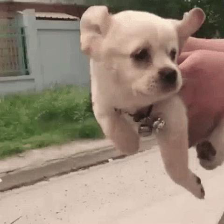

img_0.png


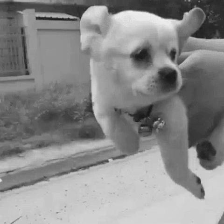

In [44]:
from IPython.display import Image 

# Display what we have in results_dir.
for filename in os.listdir(results_dir):
  print filename
  display(Image(results_dir + filename))

## Time to train our RainbowNet model!
Now we can run our model. It will save its parameters after every training session.

If you're looking to only predict, run the cell after this.

In [0]:
#print(train_dir)
#! ls ../data/train
X_train = None
Y_train = None
X_test = None
Y_test = None

In [0]:
images_train = load_data(train_dir)
X_train, Y_train = preprocess_data(images_train)
print ("Loaded training data.\n==========")

images_test = load_data(test_dir)
X_test, Y_test = preprocess_data(images_test)
# We are going to test on train for now to sanity check.
#X_test, Y_test = X_train, Y_train
print ("Loaded test data.\n==========")

preprocess_data(): obtained 44 images.
stats on channel1: min 0.0, max 255.0
stats on channel2: min 6.0, max 253.0
stats on channel3: min 0.0, max 244.0
preprocess_data(): Resizing
preprocess_data(): Creating inception embeddings
embedding is of type <type 'numpy.ndarray'>
stats on channel1: min 0.0, max 1.0
stats on channel2: min 0.0, max 1.0
stats on channel3: min 0.0, max 1.0
preprocess_data(): Separating L and ab channels
stats on channel1: min 0.0, max 100.0
stats on channel2: min -25.9207484557, max 32.2444324502
stats on channel3: min -11.4864902058, max 27.1133255833
preprocess_data(): Normalizing L channel to [0,1]
preprocess_data(): [not baseline] discretizing Y


In [33]:
 # Run the model!
rainbowModel = RainbowNetModel()

rainbowModel.compile(optimizer='adam', 
                     loss=colorization_loss,
                     metrics=['accuracy'])
                     #metrics=['top_k_categorical_accuracy'])

rainbowModel.fit(x=X_train, y=Y_train,
                 epochs=10,
                 batch_size=BATCH_SIZE)

save_model(rainbowModel, model_chkpt)

# Get predictions after we've trained.
predictions = rainbowModel.evaluate(X_test, Y_test)


ValueError: ignored

In [0]:

# Displaying our predictions
# ==========================

# The predictions are (m, H, W, NUM_VALID_BUCKETS softmax dim).
# We need to process these so they're interpretable as color images.
m, H, W, _ = predictions.shape
predicted_bucket_indices = np.argmax(predictions, axis=3)
predicted_buckets = np.zeros(predicted_bucket_indices.shape)
for i in xrange(m):
  for h in xrange(H):
    for w in xrange(W):
      index = predicted_bucket_indices[m,h,w]
      predicted_buckets[m,h,w] = BUCKET_INDEX_TO_ID(index)

# Display / output the predictions.
output_images_ab = inverse_discretize(predicted_buckets)
output_images_lab = np.concatenate((X_test, output_images_ab), axis=3) # add the L channel back somehow? It should be part of the X
image = output_images_lab[0]
# save one image
imsave(results_dir + "rainbow_img.jpg", lab2rgb(image))      # Save it.

from IPython.display import Image 

# Display what we have in results_dir.
for filename in os.listdir(results_dir):
  print filename
  display(Image(results_dir + filename))

## Predict using the model
If you don't want to train, but only use the saved model to predict something, run this cell.

In [0]:
X_test, Y_test = load_data(test_dir)

rainbowModel = load_existing_model()

predictions = rainbowModel.evaluate(X_test, Y_test)

# Display / output the predictions.
